In [1]:
!pip install numpy pandas matplotlib

Cargando archivo...
✅ Archivo cargado: 100000 filas, 7 columnas
Columnas: ['Time', 'Vout', 'Vmos', 'Vpwm_out', 'Vsource', 'V9', 'Vsim']
Rango de tiempo: 0.0000 a 0.0100 segundos
Puntos de datos: 100000


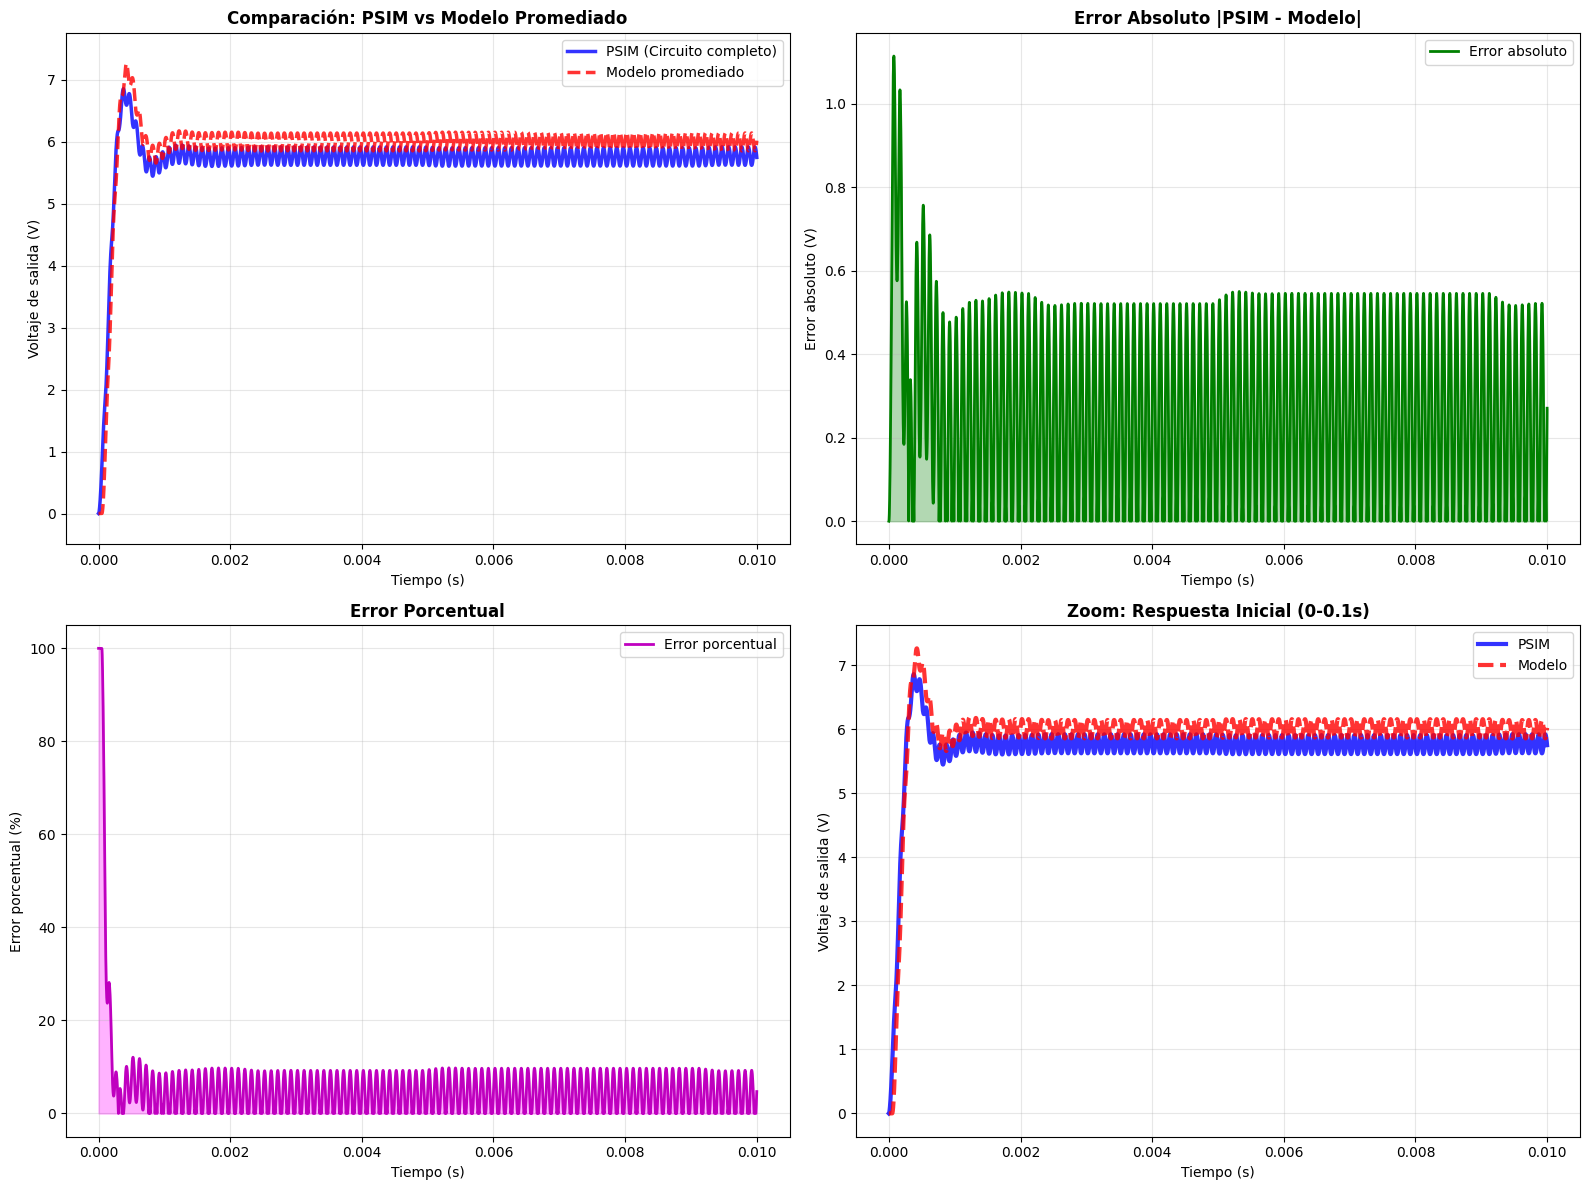


📊 MÉTRICAS DE ERROR - PSIM vs MODELO
🔸 Error RMS:                0.341931 V
🔸 Error máximo:             1.113906 V
🔸 Error promedio:           0.269407 V
🔸 Error porcentual promedio: 5.625 %
🔸 Error porcentual máximo:   100.000 %

🔍 DETECTANDO ESCALONES...
⚠️ No se detectaron escalones automáticamente. Ajusta el threshold.

📈 ANÁLISIS ESTADÍSTICO:
----------------------------------------
🔹 Error en estado estacionario: 0.257156 V
🔹 Voltaje PSIM promedio (SS):   5.7636 V
🔹 Voltaje Modelo promedio (SS): 6.0073 V
🔹 Desviación estándar PSIM:     0.108445 V
🔹 Desviación estándar Modelo:   0.105115 V

📋 RESUMEN PARA EL INFORME IEEE
• El modelo promediado presenta un error RMS de 0.3419 V
• Error porcentual promedio de 5.62%
• Error máximo de 1.1139 V (100.00%)
• En estado estacionario, el error promedio es 0.2572 V
✅ CONCLUSIÓN: El modelo es BUENO (error < 10%)

📊 Información del dataset:
   - Tiempo total simulado: 0.0100 segundos
   - Paso de simulación: 1.00e-07 segundos
   - Rango Vout 

In [2]:
# ============================================
# Análisis Convertidor Buck: PSIM vs Modelo
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuración
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.style.use('default')

# CARGAR Y PROCESAR DATOS
print("Cargando archivo...")

filepath = os.path.join(os.getcwd(), 'Traces.csv')

data = pd.read_csv(filepath)
print(f"✅ Archivo cargado: {data.shape[0]} filas, {data.shape[1]} columnas")
print(f"Columnas: {list(data.columns)}")

# Extraer datos
time = data['Time'].values
vout_psim = data['Vout'].values  # PSIM
vout_model = data['Vsim'].values  # Modelo

print(f"Rango de tiempo: {time[0]:.4f} a {time[-1]:.4f} segundos")
print(f"Puntos de datos: {len(time)}")

# ============================================
# GRÁFICOS PRINCIPALES
# ============================================

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. COMPARACIÓN DIRECTA
ax1.plot(time, vout_psim, 'b-', linewidth=2.5, label='PSIM (Circuito completo)', alpha=0.8)
ax1.plot(time, vout_model, 'r--', linewidth=2.5, label='Modelo promediado', alpha=0.8)
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Voltaje de salida (V)')
ax1.set_title('Comparación: PSIM vs Modelo Promediado', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim([min(min(vout_psim), min(vout_model))-0.5, max(max(vout_psim), max(vout_model))+0.5])

# 2. ERROR ABSOLUTO
error_abs = np.abs(vout_psim - vout_model)
ax2.plot(time, error_abs, 'g-', linewidth=2, label='Error absoluto')
ax2.fill_between(time, 0, error_abs, alpha=0.3, color='green')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Error absoluto (V)')
ax2.set_title('Error Absoluto |PSIM - Modelo|', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. ERROR PORCENTUAL
vout_psim_safe = np.where(np.abs(vout_psim) < 1e-10, 1e-10, vout_psim)
error_percent = (error_abs / np.abs(vout_psim_safe)) * 100
ax3.plot(time, error_percent, 'm-', linewidth=2, label='Error porcentual')
ax3.fill_between(time, 0, error_percent, alpha=0.3, color='magenta')
ax3.set_xlabel('Tiempo (s)')
ax3.set_ylabel('Error porcentual (%)')
ax3.set_title('Error Porcentual', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. ZOOM EN LOS ESCALONES (primeros 0.1 segundos)
mask = time <= 0.1
ax4.plot(time[mask], vout_psim[mask], 'b-', linewidth=3, label='PSIM', alpha=0.8)
ax4.plot(time[mask], vout_model[mask], 'r--', linewidth=3, label='Modelo', alpha=0.8)
ax4.set_xlabel('Tiempo (s)')
ax4.set_ylabel('Voltaje de salida (V)')
ax4.set_title('Zoom: Respuesta Inicial (0-0.1s)', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

# ============================================
# MÉTRICAS DE ERROR
# ============================================

# Calcular métricas
error_rms = np.sqrt(np.mean((vout_psim - vout_model)**2))
error_max = np.max(error_abs)
error_mean = np.mean(error_abs)
error_percent_mean = np.mean(error_percent)
error_percent_max = np.max(error_percent)

print("\n" + "="*60)
print("📊 MÉTRICAS DE ERROR - PSIM vs MODELO")
print("="*60)
print(f"🔸 Error RMS:                {error_rms:.6f} V")
print(f"🔸 Error máximo:             {error_max:.6f} V")
print(f"🔸 Error promedio:           {error_mean:.6f} V")
print(f"🔸 Error porcentual promedio: {error_percent_mean:.3f} %")
print(f"🔸 Error porcentual máximo:   {error_percent_max:.3f} %")
print("="*60)

# ============================================
# DETECCIÓN AUTOMÁTICA DE ESCALONES
# ============================================

print("\n🔍 DETECTANDO ESCALONES...")

# Detectar cambios bruscos en Vout PSIM
diff_vout = np.diff(vout_psim)
threshold = 0.05  # Umbral para detectar escalones
step_indices = np.where(np.abs(diff_vout) > threshold)[0]

if len(step_indices) > 0:
    step_times = time[step_indices]
    print(f"✅ Escalones detectados en los tiempos: {step_times}")

    # Gráfico enfocado en escalones
    plt.figure(figsize=(14, 8))
    plt.plot(time, vout_psim, 'b-', linewidth=2.5, label='PSIM', alpha=0.8)
    plt.plot(time, vout_model, 'r--', linewidth=2.5, label='Modelo', alpha=0.8)

    # Marcar escalones
    colors = ['orange', 'purple', 'brown', 'pink']
    for i, t_step in enumerate(step_times[:4]):  # Máximo 4 escalones
        color = colors[i % len(colors)]
        plt.axvline(x=t_step, color=color, linestyle=':', linewidth=2,
                   label=f'Escalón {i+1}: t={t_step:.4f}s')

    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje de salida (V)')
    plt.title('🎯 Análisis de Escalones: PSIM vs Modelo', fontweight='bold', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

else:
    print("⚠️ No se detectaron escalones automáticamente. Ajusta el threshold.")

# ============================================
# ANÁLISIS ESTADÍSTICO POR REGIÓN
# ============================================

print("\n📈 ANÁLISIS ESTADÍSTICO:")
print("-"*40)

# Estado estacionario (últimos 20% de datos)
ss_start = int(0.8 * len(time))
vout_psim_ss = vout_psim[ss_start:]
vout_model_ss = vout_model[ss_start:]
error_ss = np.mean(np.abs(vout_psim_ss - vout_model_ss))

print(f"🔹 Error en estado estacionario: {error_ss:.6f} V")
print(f"🔹 Voltaje PSIM promedio (SS):   {np.mean(vout_psim_ss):.4f} V")
print(f"🔹 Voltaje Modelo promedio (SS): {np.mean(vout_model_ss):.4f} V")
print(f"🔹 Desviación estándar PSIM:     {np.std(vout_psim_ss):.6f} V")
print(f"🔹 Desviación estándar Modelo:   {np.std(vout_model_ss):.6f} V")

# ============================================
# RESUMEN PARA EL INFORME
# ============================================

print("\n" + "="*60)
print("📋 RESUMEN PARA EL INFORME IEEE")
print("="*60)
print(f"• El modelo promediado presenta un error RMS de {error_rms:.4f} V")
print(f"• Error porcentual promedio de {error_percent_mean:.2f}%")
print(f"• Error máximo de {error_max:.4f} V ({error_percent_max:.2f}%)")
print(f"• En estado estacionario, el error promedio es {error_ss:.4f} V")

if error_percent_mean < 5:
    print("✅ CONCLUSIÓN: El modelo es MUY BUENO (error < 5%)")
elif error_percent_mean < 10:
    print("✅ CONCLUSIÓN: El modelo es BUENO (error < 10%)")
elif error_percent_mean < 20:
    print("⚠️ CONCLUSIÓN: El modelo es ACEPTABLE (error < 20%)")
else:
    print("❌ CONCLUSIÓN: El modelo necesita MEJORAS (error > 20%)")

print("="*60)

# Mostrar información del dataset
print(f"\n📊 Información del dataset:")
print(f"   - Tiempo total simulado: {time[-1]:.4f} segundos")
print(f"   - Paso de simulación: {np.mean(np.diff(time)):.2e} segundos")
print(f"   - Rango Vout PSIM: {np.min(vout_psim):.3f} a {np.max(vout_psim):.3f} V")
print(f"   - Rango Vout Modelo: {np.min(vout_model):.3f} a {np.max(vout_model):.3f} V")

print("\n🎉 ¡Análisis completado! Los gráficos y métricas están listos para tu informe.")